In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine)


In [6]:
# View all of the classes that automap found
print(Base.classes.keys())


['measurement', 'station']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(f"The most recent date in the climate dataset is: {most_recent_date[0]}")


The most recent date in the climate dataset is: 2017-08-23


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = most_recent_date[0]  

# Calculate the date one year from the last date in data set.
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)


In [11]:
# Perform a query to retrieve the data and precipitation scores
query1 = """
SELECT date, prcp
FROM measurement
WHERE date >= (
    SELECT date(MAX(date), '-1 year')
    FROM measurement
)
ORDER BY date;
"""
results = engine.execute(query1)

In [12]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_data = pd.DataFrame(results, columns=['date', 'precipitation'])


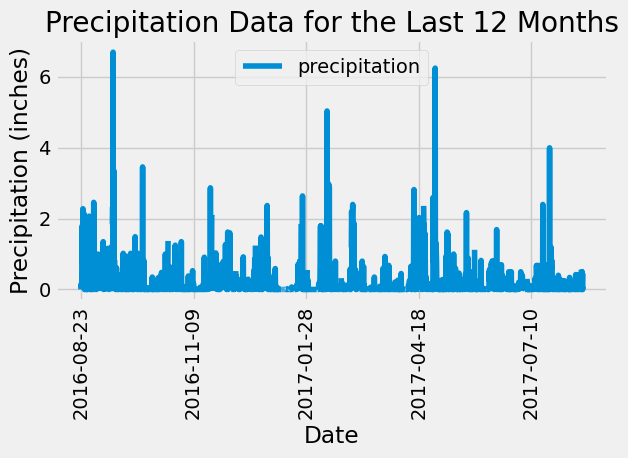

In [14]:
# Sort the dataframe by date
precip_data = precip_data.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
precip_data.plot(x='date', y='precipitation', rot=90)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Data for the Last 12 Months')
plt.tight_layout()
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_data.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset
query2 = "SELECT COUNT(DISTINCT station) AS station_count FROM measurement;"
connection = engine.connect()
result_v2 = connection.execute(query2).fetchone()
total_stations = result_v2["station_count"]
print(f"Total number of stations: {total_stations}")


Total number of stations: 9


In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# Design a query to find the most active stations and their row counts in descending order
query3 = """
SELECT station, COUNT(*) AS row_count
FROM measurement
GROUP BY station
ORDER BY row_count DESC;
"""
result_v3 = connection.execute(query3).fetchall()
print("Most Active Stations:")
for row in result_v3:
    print(f"Station: {row['station']}, Row Count: {row['row_count']}")


Most Active Stations:
Station: USC00519281, Row Count: 2772
Station: USC00519397, Row Count: 2724
Station: USC00513117, Row Count: 2709
Station: USC00519523, Row Count: 2669
Station: USC00516128, Row Count: 2612
Station: USC00514830, Row Count: 2202
Station: USC00511918, Row Count: 1979
Station: USC00517948, Row Count: 1372
Station: USC00518838, Row Count: 511


In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = result_v3[0]["station"]
query4 = f"""
SELECT MIN(tobs) AS min_temp, MAX(tobs) AS max_temp, AVG(tobs) AS avg_temp
FROM measurement
WHERE station = '{most_active_station}';
"""

In [20]:
result_v4 = connection.execute(query4).fetchone()
min_temp = result_v4["min_temp"]
max_temp = result_v4["max_temp"]
avg_temp = result_v4["avg_temp"]
print(f"Temperature Summary for the Most Active Station ({most_active_station}):")
print(f"Lowest Temperature: {min_temp}")
print(f"Highest Temperature: {max_temp}")
print(f"Average Temperature: {avg_temp}")

Temperature Summary for the Most Active Station (USC00519281):
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


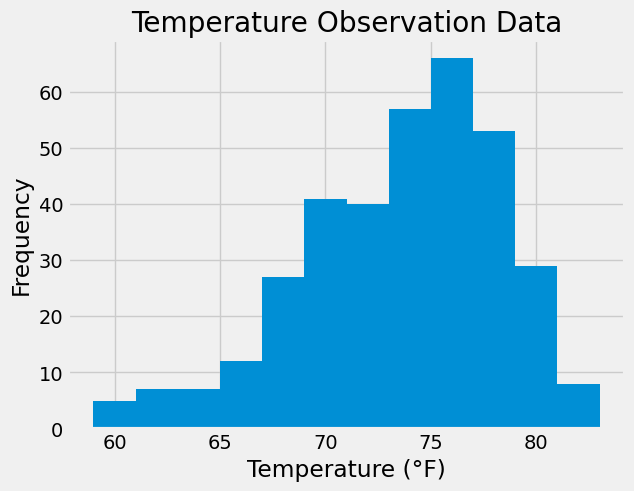

In [26]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query5 = f"""
SELECT tobs
FROM measurement
WHERE station = '{most_active_station}' AND date >= (
    SELECT date(MAX(date), '-1 year')
    FROM measurement
);
"""
result_v5 = connection.execute(query5).fetchall()

# Extract the temperature values from the result
temperatures = [row['tobs'] for row in result_v5]

df = pd.DataFrame(result_v5, columns=["temperature"])
plt.hist(df["temperature"], bins=12)
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.title("Temperature Observation Data")
plt.show()

# Close Session

In [27]:
# Close Session
session.close()